# Importing Packages

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm.notebook import tqdm

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, regularizers, optimizers, applications
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.resnet50 import ResNet50

from sklearn.metrics import confusion_matrix

%reload_ext autoreload
%autoreload 2
from utils import *


# ResNet50

In [3]:
cnn_base = ResNet50(include_top=False,
                    weights="imagenet",
                    input_shape=(224, 224, 3))

model = models.Sequential()
model.add(cnn_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=64, activation='relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units=128, activation='relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units=256, activation='relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units=128, activation='relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units=1, activation='sigmoid'))

cnn_base.trainable = False

In [4]:
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test2'

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_fldr,
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42
)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (224, 224),
        batch_size = 1,
        class_mode = 'binary',
        shuffle = False,
        seed = 42)

Found 3830 images belonging to 2 classes.
Found 678 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


In [5]:
model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(learning_rate=0.01),
              metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])

In [7]:
filepath = '../models/Resnet.h5'
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')

history = model.fit_generator(generator = train_generator,
                              epochs = 20,
                              callbacks = [earlyStopping, mcp_save],
                              validation_data = val_generator,
                              steps_per_epoch = 20) 

Epoch 1/20
20/20 [==============================] - 363s 19s/step - loss: 16.7523 - accuracy: 0.5110 - precision: 0.6220 - recall: 0.5917 - auc: 0.4550 - auc_1: 0.5988 - val_loss: 0.5717 - val_accuracy: 0.9587 - val_precision: 0.9587 - val_recall: 1.0000 - val_auc: 0.5000 - val_auc_1: 0.9587
Epoch 2/20
20/20 [==============================] - 328s 17s/step - loss: 0.7706 - accuracy: 0.6474 - precision: 0.6709 - recall: 0.9455 - auc: 0.4523 - auc_1: 0.6655 - val_loss: 0.4857 - val_accuracy: 0.9587 - val_precision: 0.9587 - val_recall: 1.0000 - val_auc: 0.5000 - val_auc_1: 0.9587
Epoch 3/20
20/20 [==============================] - 298s 15s/step - loss: 0.6731 - accuracy: 0.6221 - precision: 0.6221 - recall: 1.0000 - auc: 0.4076 - auc_1: 0.5644 - val_loss: 0.4725 - val_accuracy: 0.9587 - val_precision: 0.9587 - val_recall: 1.0000 - val_auc: 0.5000 - val_auc_1: 0.9587
Epoch 4/20
20/20 [==============================] - 283s 15s/step - loss: 0.6110 - accuracy: 0.7168 - precision: 0.7168 - r

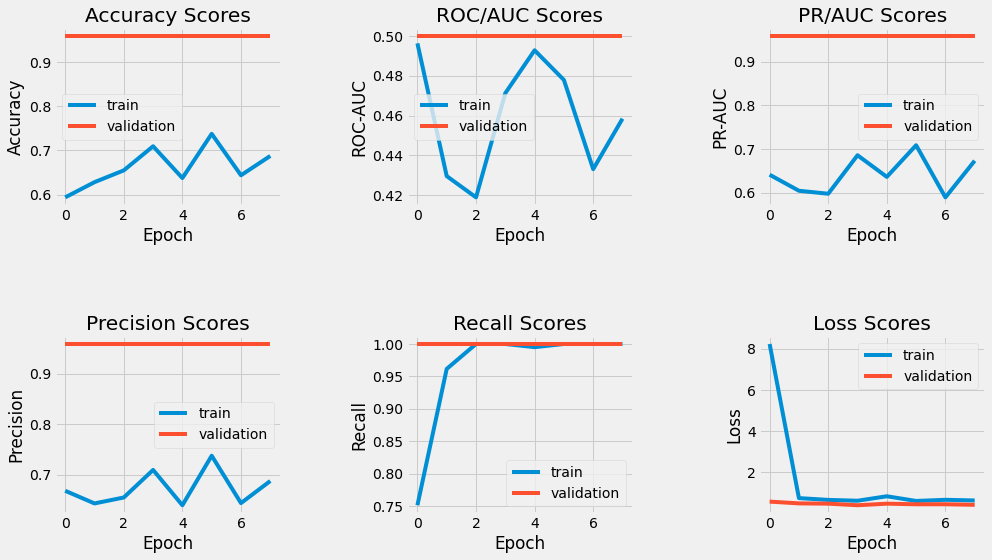

In [8]:
sixplot(history, 'auc', 'val_auc', 'auc_1', 'val_auc_1', 'precision', 'val_precision', 'recall', 'val_recall')

In [10]:
hist_df = pd.DataFrame(history.history)
hist_df

,loss,accuracy,precision,recall,auc,auc_1,val_loss,val_accuracy,val_precision,val_recall,val_auc,val_auc_1
0,8.227907,0.593750,0.668085,0.751196,0.496336,0.641167,0.571653,0.958702,0.958702,1.0,0.5,0.958702
1,0.741764,0.628125,0.643087,0.961538,0.429537,0.604439,0.485744,0.958702,0.958702,1.0,0.5,0.958702
2,0.654701,0.654839,0.654839,1.000000,0.418834,0.597624,0.472493,0.958702,0.958702,1.0,0.5,0.958702
3,0.613993,0.709375,0.709375,1.000000,0.471271,0.685780,0.395665,0.958702,0.958702,1.0,0.5,0.958702
4,0.830817,0.637500,0.639498,0.995122,0.492874,0.636239,0.471343,0.958702,0.958702,1.0,0.5,0.958702
5,0.603918,0.737500,0.737500,1.000000,0.477931,0.708759,0.442330,0.958702,0.958702,1.0,0.5,0.958702
6,0.659130,0.643750,0.643750,1.000000,0.433040,0.589335,0.443566,0.958702,0.958702,1.0,0.5,0.958702
7,0.626881,0.687500,0.687500,1.000000,0.458432,0.673223,0.414950,0.958702,0.958702,1.0,0.5,0.958702


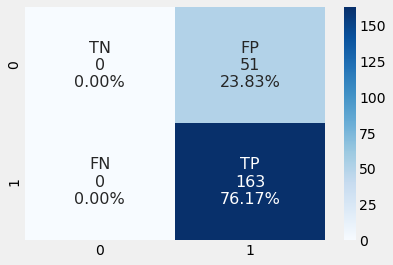

In [11]:
probabilities = model.predict_generator(test_generator)
y_true = test_generator.classes
y_pred = probabilities > 0.5
make_confusion_matrix(y_true, y_pred)

# AlexNet

In [21]:
#Instantiation
AlexNet = Sequential()
AlexNet.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
AlexNet.add(Flatten())
AlexNet.add(Dense(4096, input_shape=(224, 224, 3, )))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(Dropout(0.4))
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(Dropout(0.4))
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(Dropout(0.4))
AlexNet.add(Dense(1))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('sigmoid'))

In [22]:
AlexNet.compile(loss = 'binary_crossentropy',
                optimizer = Adam(learning_rate=0.01),
                # optimizer = RMSprop(lr=2e-5),
                metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])

In [23]:
filepath = '../models/Alexnet.h5'
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')

history2 = AlexNet.fit_generator(generator = train_generator,
                                 epochs = 10,
                                 callbacks = [earlyStopping, mcp_save],
                                 validation_data = val_generator,
                                 steps_per_epoch = 20) 

Epoch 1/10
20/20 [==============================] - 537s 28s/step - loss: 0.5620 - accuracy: 0.7685 - precision_3: 0.7832 - recall_3: 0.8877 - auc_6: 0.7562 - auc_7: 0.8083 - val_loss: 239663.5938 - val_accuracy: 0.0413 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_6: 0.5000 - val_auc_7: 0.9587
Epoch 2/10
20/20 [==============================] - 562s 29s/step - loss: 0.4606 - accuracy: 0.8225 - precision_3: 0.8192 - recall_3: 0.9603 - auc_6: 0.8502 - auc_7: 0.9173 - val_loss: 6320.4844 - val_accuracy: 0.0413 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_6: 0.5000 - val_auc_7: 0.9587
Epoch 3/10
20/20 [==============================] - 500s 26s/step - loss: 0.4609 - accuracy: 0.8090 - precision_3: 0.7990 - recall_3: 0.9619 - auc_6: 0.8612 - auc_7: 0.9285 - val_loss: 760.6014 - val_accuracy: 0.0413 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_6: 0.5000 - val_auc_7: 0.9587
Epoch 4/10
20/20 [==============================] - 44

KeyboardInterrupt: 

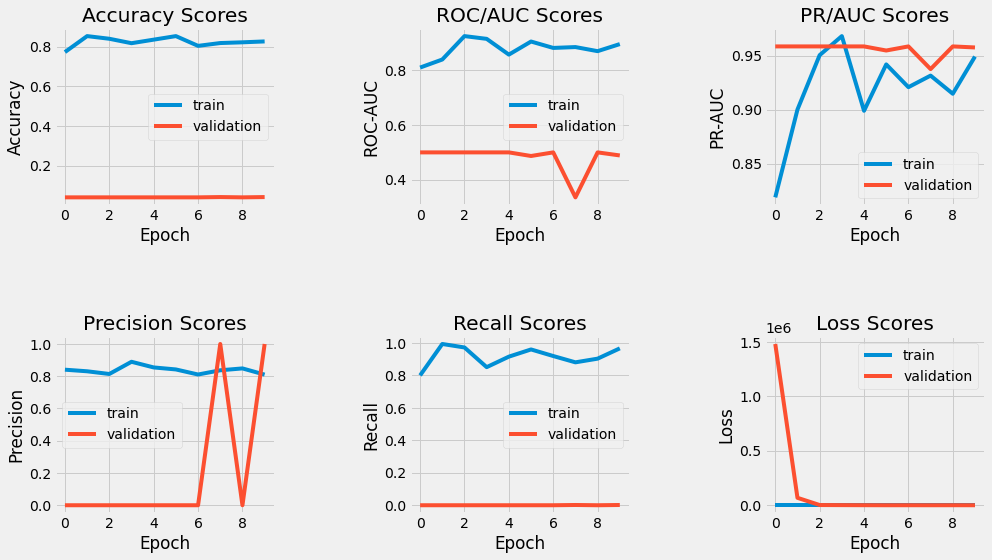

In [30]:
sixplot(history2, 'auc_4', 'val_auc_4', 'auc_5', 'val_auc_5', 'precision_2', 'val_precision_2', 'recall_2', 'val_recall_2')

In [31]:
hist_df_2 = pd.DataFrame(history2.history)
hist_df_2

,loss,accuracy,precision_2,recall_2,auc_4,auc_5,val_loss,val_accuracy,val_precision_2,val_recall_2,val_auc_4,val_auc_5
0,0.526756,0.772321,0.840580,0.800000,0.810301,0.818782,1.481458e+06,0.041298,0.0,0.000000,0.500000,0.958702
1,0.475467,0.852679,0.830688,0.993671,0.839758,0.900164,6.817648e+04,0.041298,0.0,0.000000,0.500000,0.958702
2,0.404099,0.839286,0.813953,0.972222,0.925391,0.950601,1.937265e+03,0.041298,0.0,0.000000,0.500000,0.958702
3,0.411577,0.816964,0.889610,0.850932,0.915311,0.968259,1.121600e+03,0.041298,0.0,0.000000,0.500000,0.958702
4,0.409318,0.834821,0.854545,0.915584,0.857699,0.899029,4.238093e+02,0.041298,0.0,0.000000,0.500000,0.958702
5,0.383294,0.852679,0.842105,0.960000,0.905541,0.942021,3.121670e+01,0.041298,0.0,0.000000,0.486841,0.954900
6,0.400937,0.803571,0.810651,0.919463,0.882148,0.920921,1.553907e+02,0.041298,0.0,0.000000,0.500000,0.958702
7,0.423220,0.817757,0.836879,0.880597,0.885261,0.931641,3.877418e+00,0.042773,1.0,0.001538,0.335495,0.937682
8,0.397718,0.821429,0.848485,0.903226,0.870313,0.914815,2.510311e+02,0.041298,0.0,0.000000,0.500000,0.958702
9,0.384926,0.825893,0.810056,0.966667,0.896171,0.949304,4.143155e+01,0.042773,1.0,0.001538,0.488819,0.957727


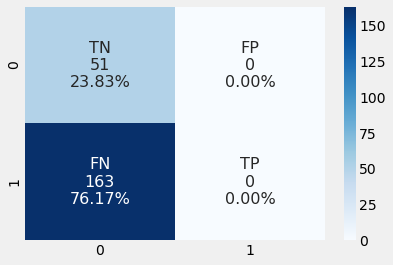

In [32]:
probabilities = AlexNet.predict_generator(test_generator)
y_true = test_generator.classes
y_pred = probabilities > 0.5
make_confusion_matrix(y_true, y_pred)

In [ ]:
base_model = applications.resnet50.ResNet50(include_top=False, input_shape=(256, 256, 3), weights="imagenet")
base_model.trainable = False

model = models.Sequential([
        base_model,
        layers.Conv2D(32, (3, 3), activation="relu"),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='softmax'),
])

model.compile(loss = 'binary_crossentropy', 
              optimizer = Adam(learning_rate=0.01),
              metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])

In [ ]:
history_3 = model.fit(train_generator, 
                      epochs = 5,
                      steps_per_epoch = 20,
                      validation_data = val_generator,
                      validation_steps = 20)

In [ ]:
base_model = keras.applications.ResNet50(weights= None, include_top=False, input_shape= (256, 256, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)

predictions = Dense(2, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

model.compile(loss = 'binary_crossentropy', 
              optimizer = Adam(learning_rate=0.01),
              metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])